### Load libraries and set variables

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%matplotlib widget
import json
import os
import matplotlib.pyplot as plt
import time
import glob
import cv2
import numpy as np
from modules.input_reader import ImageReader
from modules.draw import Plotter3d, draw_poses
from modules.parse_poses import parse_poses
from torchsummary import summary
from modules.inference_engine_pytorch import InferenceEnginePyTorch
from mpl_toolkits import mplot3d

In [2]:
def rotate_poses(poses_3d, R, t):
    R_inv = np.linalg.inv(R)
    for pose_id in range(len(poses_3d)):
        pose_3d = poses_3d[pose_id].reshape((-1, 4)).transpose()
        pose_3d[0:3, :] = np.dot(R_inv, pose_3d[0:3, :] - t)
        poses_3d[pose_id] = pose_3d.transpose().reshape(-1)

    return poses_3d

In [3]:
strides = 8
file_path = os.path.join('data', 'extrinsics.json')
with open(file_path, 'r') as f:
    extrinsics = json.load(f)
R = np.array(extrinsics['R'], dtype=np.float32)
t = np.array(extrinsics['t'], dtype=np.float32)
frame_provider = ImageReader(files)
is_video = True
base_height =256
fx = -1
delay = 1
esc_code = 27
p_code = 112
space_code = 32
mean_time = 0

In [4]:
net = InferenceEnginePyTorch("models\\human-pose-estimation-3d.pth", "cpu")
canvas_3d = np.zeros((720, 1280, 3), dtype=np.uint8)
plotter = Plotter3d(canvas_3d.shape[:2])
canvas_3d_window_name = 'Canvas 3D'

No CUDA device found, inferring on CPU


#### Extract poses from the first frame and perform infererence on the CPU with Pytorch

In [5]:
for idx, frame in enumerate(frame_provider):
    global fx
    global strides
    if idx == 1:
        break
    current_time = cv2.getTickCount()
    if frame is None:
        print(f"at frame {idx}, but skipping because it's empty")
        pass
    input_scale = base_height / frame.shape[0]
    scaled_img = cv2.resize(frame, dsize=None, fx=input_scale, fy=input_scale)
    scaled_img = scaled_img[:, 0:scaled_img.shape[1] - (scaled_img.shape[1] % strides)]  # better to pad, but cut out for demo
    if fx < 0:  # Focal length is unknown
        fx = np.float32(0.8 * frame.shape[1])
    t0 = time.time()
    inference_results = net.infer(scaled_img)
    time_delta = np.round([time.time() - t0], 3)
    print(f"{idx}: Inference time: {time_delta}")
    poses_3d, poses_2d = parse_poses(inference_results, input_scale, strides, fx, is_video)

0: Inference time: [1.389]
num_keypoints 18


In [6]:
if len(poses_3d):
    poses_3d = rotate_poses(poses_3d, R, t)
    poses_3d_copy = poses_3d.copy()
    x = poses_3d_copy[:, 0::4]
    y = poses_3d_copy[:, 1::4]
    z = poses_3d_copy[:, 2::4]
    
    poses_3d[:, 0::4], poses_3d[:, 1::4], poses_3d[:, 2::4] = -z, x, -y

    poses_3d = poses_3d.reshape(poses_3d.shape[0], 19, -1)[:, :, 0:3]

In [7]:
poses_3d.shape

(1, 19, 3)

C:\Users\eyast\AppData\Local\Temp\ipykernel_32052\2117136038.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter3D(X, Y, Z, Z, cmap='Greens')
c:\Users\eyast\Miniconda3\envs\communities\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:1104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
c:\Users\eyast\Miniconda3\envs\communities\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:1106: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':


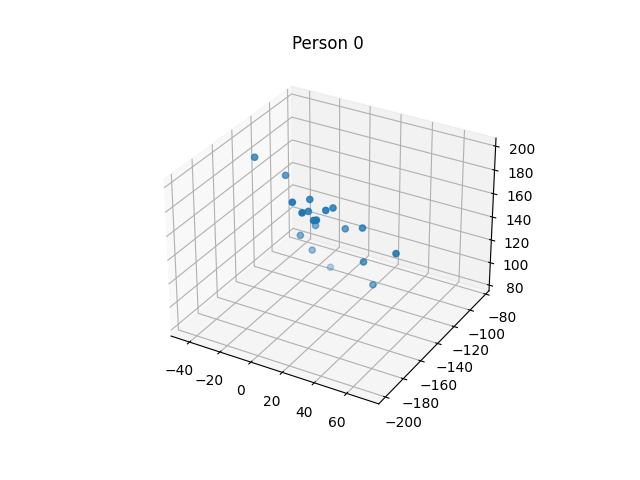

In [8]:
for p_idx, person in enumerate(poses_3d):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    X = person[:, 0]
    Y = person[:, 1]
    Z = person[:, 2]
    max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max()
    Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X.max()+X.min())
    Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y.max()+Y.min())
    Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(Z.max()+Z.min())
# Comment or uncomment following both lines to test the fake bounding box:
    for xb, yb, zb in zip(Xb, Yb, Zb):
        ax.plot([xb], [yb], [zb], 'w')
    ax.scatter3D(X, Y, Z, Z, cmap='Greens')
    plt.title(f"Person {p_idx}")
    plt.show()

In [9]:
cv2.namedWindow(canvas_3d_window_name)
cv2.setMouseCallback(canvas_3d_window_name, Plotter3d.mouse_callback)
edges = (Plotter3d.SKELETON_EDGES + 19 * np.arange(poses_3d.shape[0]).reshape((-1, 1, 1))).reshape((-1, 2))
plotter.plot(canvas_3d, poses_3d, edges)
cv2.imshow(canvas_3d_window_name, canvas_3d)

: 